In [1]:
# Libraries:
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..'))) # include parent directory in the path
from data import SINDy_data
from data import data
from data import equations

sys.path.append("/home/mattg/D_CODE") # A questo punto è necessario per non doverlo chiamare i file che usano D_CODE.
from toolbox.auxiliary_functions import SRT_simulation, D_CODE_simulation, set_param_freq

# Seed:
np.random.seed(999)

/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


### Case $\rho$ varying
Consider the following fractional system of ODEs: 
$$
\begin{cases}
\dot{x}_0 = \dfrac{x_0^2}{x_1 + \rho} \\[10pt]
\dot{x}_1 = 1
\end{cases}
$$

With $\rho\in[1,2]$ varying.

In [2]:
# Select ODE & settings:
ode_name = 'FracODE_par_rho' # help="name of the ode", type=str
ode_param = None # help="parameters of the ode (default: None)", type=str, default=None
freq = 10 # help="sampling frequency", type=float, default=10
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_ratio = 0.01 # help="noise level (default 0)", type=float, default=0.
seed = 100 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10

ode_param, freq = set_param_freq(ode_param, freq)

ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 2
dim_k = 1
time_vector = np.arange(0, ode.T + dt, dt)
T = ode.T

In [3]:
# running SR-T:
building_blocks_lambda0, function_names0 = SRT_simulation(ode_name, ode_param, 0, freq, n_sample, noise_ratio, alg='tv', seed=seed, n_seed=n_seed, T=T)
building_blocks_lambda1, function_names1 = SRT_simulation(ode_name, ode_param, 1, freq, n_sample, noise_ratio, alg='tv', seed=seed, n_seed=n_seed, T=T)

Running with: ode_name=FracODE_par_rho, ode_param=None, x_id=0, freq=10, n_sample=50, noise_sigma=0.01, alg=tv, seed=100, n_seed=1
Dataset shape:  (31, 50, 3)
Functions set:  {'neg': 1, 'mul': 1, 'div': 1, 'add': 1, 'pow': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.78          458.021       13         0.117615           0.0981      2.78m
   1     7.17          490.426        7        0.0852851        0.0739505      3.65m
   2     6.10          260.359       11        0.0577844        0.0513537      2.62m


/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/gplearn/functions.py:132: RuntimeWarning: overflow encountered in power
  return np.where(np.logical_and(np.minimum(x1, x2) >= 0, np.maximum(x1, x2) <= 10), np.power(x1, x2), 1000)


   3     7.05           540.04        7        0.0556913        0.0701919      2.56m
   4     6.90           494.19        7        0.0533663        0.0911171      2.39m
   5     7.03          845.563        7        0.0524685        0.0991975      2.10m
   6     7.15          909.682        7        0.0517639         0.105538      1.89m
   7     6.99          566.816        7        0.0518353         0.104896      1.67m
   8     6.99          232.711        7        0.0505411         0.116544      1.52m
   9     7.04          277.626        7          0.05087         0.113584      1.58m
  10     7.00          759.099        7        0.0514117         0.108708      1.57m
  11     6.98          265.428        7        0.0510226          0.11221      1.17m
  12     6.99          294.876        7        0.0507177         0.114954      1.00m

SR-T model:  X0**2/(X1 + X2)

building blocks:
X0**1.9419079365336827
X0**2
1/(X1 + X2)
 
number of building blocks:  3
 
Running with: ode_name=Frac

##### Plot per report

In [ ]:
from scipy.integrate import solve_ivp
import numpy as np

class SRModel:
    def __init__(self, f):
        self.f = f  # la funzione dinamica, es. f = lambda z,t: [z[1], -np.sin(z[0])]
    
    def simulate(self, x0, t, u=None):
        # u ignorato, lo metti solo per compatibilità con SINDy
        sol = solve_ivp(lambda t, z: self.f(z, t), [t[0], t[-1]], x0, t_eval=t, vectorized=False)
        return sol.y.T  # restituisce shape (len(t), dim_x)
    
f = lambda x,t: [x[0]**2/(x[1] + x[2]), 
                 1,
                 0]
model = SRModel(f)

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def evaluate_traj(model, ode, freq, n_sample, init_high, init_low, dim_x=1, dim_k=1, title=None, T_aux=100):

    np.random.seed(666)
    dt = 1 / freq
    time_vector = np.arange(0, T_aux + dt, dt)
    t = np.arange(0, T_aux, dt)
    T_plot = len(t)

    # true trajectories:
    # Assumiamo che 'data' sia disponibile nell'ambiente
    dg_true = data.DataGenerator(ode, T_aux, freq, n_sample, noise_sigma=0., init_high=init_high, init_low=init_low)
    xt_true = dg_true.xt

    # estimated trajectories:
    pred_0_list = []
    for i in range(n_sample):
        correct_param = xt_true[0, i, -dim_k:]
        t = np.arange(0, T_aux, dt)
        T_plot = len(t)
        test_params = np.tile(correct_param, (T_plot, 1))
        if dim_k != 0:
            pred_0 = model.simulate(xt_true[0, i, :], t=t[:T_plot], u=test_params)
        else:
            pred_0 = model.simulate(xt_true[0, i, :], t=t[:T_plot])
        pred_0_list.append(pred_0)

    xt_true = xt_true[:len(pred_0), :, :]
    time_vector = time_vector[:len(pred_0)]
    if dim_k != 0:
        xt_true = xt_true[:, :, :-dim_k]
    xt_true = xt_true.squeeze()
    pred_0_list = np.transpose(pred_0_list, (1, 0, 2))
    pred_0_list = pred_0_list.squeeze()

    if n_sample == 1:
        if dim_x == 1:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4))
            ax.plot(time_vector, pred_0_list, color='blue', linewidth=1.0, alpha=0.7, label=r'Estimated Trajectory')
            ax.plot(time_vector, xt_true, color='red', linewidth=1.0, linestyle='--', label=r'Correct Trajectory')
            ax.scatter(time_vector[0], xt_true[0], color='green', label=r'Start')
            ax.scatter(time_vector[-1], xt_true[-1], color='red', label=r'End')
            ax.set_xlabel(r'$t$')
            ax.set_ylabel(r'$x$')
            if title:
                ax.set_title(r'%s' % title)
            ax.legend(fontsize=9, loc='upper left')
            ax.grid(True)

        elif dim_x == 2:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4))
            # INVERTIAMO x1 e x2 nei dati
            ax.plot(pred_0_list[:, 1], pred_0_list[:, 0],
                    color='blue', linewidth=1.0, alpha=0.7, label=r'Estimated Trajectory')
            ax.plot(xt_true[:, 1], xt_true[:, 0],
                    color='red', linewidth=1.0, linestyle='--', label=r'Correct Trajectory')
            ax.scatter(xt_true[:, 1][0], xt_true[:, 0][0], color='green', label=r'Start')
            ax.scatter(xt_true[:, 1][-1], xt_true[:, 0][-1], color='red', label=r'End')
            ax.set_xlabel(r'$t$')  # ORIZZONTALE → t
            ax.set_ylabel(r'$x$')  # VERTICALE → x
            if title:
                ax.set_title(r'%s' % title)
            ax.legend(fontsize=9, loc='upper left')
            ax.grid(True)


        else:  # dim_x == 3
            fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': '3d'})
            ax.plot(pred_0_list[:, 0], pred_0_list[:, 1], pred_0_list[:, 2],
                    color='blue', linewidth=1.0, alpha=0.7, label=r'Estimated Trajectory')
            ax.plot(xt_true[:, 0], xt_true[:, 1], xt_true[:, 2],
                    color='red', linewidth=1.0, linestyle='--', label=r'Correct Trajectory')
            ax.scatter(xt_true[:, 0][0], xt_true[:, 1][0], xt_true[:, 2][0], color='green', label=r'Start')
            ax.scatter(xt_true[:, 0][-1], xt_true[:, 1][-1], xt_true[:, 2][-1], color='red', label=r'End')
            ax.set_xlabel(r'$x$')
            ax.set_ylabel(r'$y$')
            ax.set_zlabel(r'$z$')
            if title:
                ax.set_title(r'%s' % title)
            ax.legend(fontsize=9, loc='upper left')
            ax.grid(True)

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error

def evaluate_RMSE(model, ode, freq, n_sample, init_high, init_low, dim_k=1):
    # function computing the RMSE (and the MSE) of a given model: 

    np.random.seed(666)
    dt = 1 / freq
    TIME = min(ode.T, 100) 

    # true trajectories:
    dg_true = data.DataGenerator(ode, TIME, freq, n_sample, noise_sigma=0., init_high=init_high, init_low=init_low)
    xt_true = dg_true.xt
    print(np.shape(xt_true))

    # estimated trajectories:
    pred_0_list = []
    for i in range(n_sample):

        correct_param = xt_true[0, i, -dim_k:]
        #print(np.shape(correct_param))

        t = np.arange(0,TIME,dt)
        T_plot = len(t)
        test_params = np.tile(correct_param, (T_plot,1))
        if dim_k != 0:
            pred_0 = model.simulate(xt_true[0, i, :], t= t[:T_plot])[:,:-dim_k]
        else: # dim_k == 0
            pred_0 = model.simulate(xt_true[0, i, :], t= t[:T_plot])
        pred_0_list.append(pred_0)
    #print(np.shape(pred_0_list))


    xt_true = xt_true[:len(pred_0), :, :]
    if dim_k != 0:
        xt_true = xt_true[:, :, :-dim_k]
    xt_true = xt_true.squeeze()
    #print(np.shape(xt_true)) #(151, 25, 2)
    pred_0_list = np.transpose(pred_0_list, (1, 0, 2))
    pred_0_list = pred_0_list.squeeze()
    #print(np.shape(pred_0_list)) #(151, 25, 2)

    # RMSE:
    rmse_0_list = []
    mse_0_list = []
    for i in range(n_sample):
        rmse_0 = root_mean_squared_error(xt_true[:, i], pred_0_list[:,i]) 
        mse_0 = mean_squared_error(xt_true[:, i], pred_0_list[:,i])
        rmse_0_list.append(rmse_0)
        mse_0_list.append(mse_0)
    rmse_0 = np.mean(rmse_0_list)
    mse_0 = np.mean(mse_0_list)
    return rmse_0, mse_0

(31, 10, 3)
SR_T Model RMSE:  0.0010717284776675974


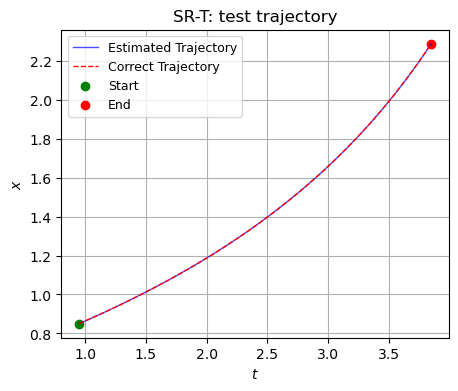

In [37]:
n_test = 10
rmse, _ = evaluate_RMSE(model, ode, freq, n_test, [1., 1., 2], [0.8, 0.8, 1], dim_k)
print('SR_T Model RMSE: ', rmse)

evaluate_sample = 1
ics = [0.85, 0.95, 1.7]
title = 'SR-T: test trajectory'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=3)

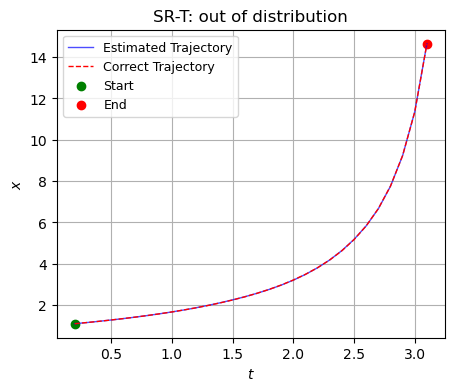

In [38]:
evaluate_sample = 1
ics = [1.1, 0.2, 2]
title = 'SR-T: out of distribution'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=3)

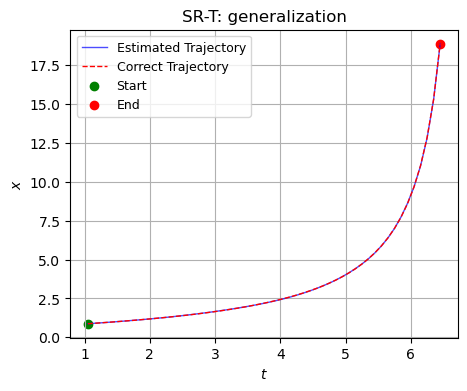

In [39]:
evaluate_sample = 1
ics = [0.85, 0.95, 1.7]
title = 'SR-T: generalization'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=5.5)

In [4]:
# running D-CODE
building_blocks_lambda0, function_names0 = D_CODE_simulation(ode_name, ode_param, 0, freq, n_sample, noise_ratio, seed=seed, n_seed=n_seed, T=T)
building_blocks_lambda1, function_names1 = D_CODE_simulation(ode_name, ode_param, 1, freq, n_sample, noise_ratio, seed=seed, n_seed=n_seed, T=T)

Running with: ode_name=FracODE_par_rho, ode_param=None, x_id=0, freq=10, n_sample=50, noise_sigma=0.01, seed=100, n_seed=1
Dataset shape:  (31, 50, 3)
Functions set:  {'neg': 1, 'mul': 1, 'div': 1, 'add': 1, 'pow': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.78      2.73142e+11        7         0.549305         0.799674      2.45m
   1     8.68      4.50169e+10        7         0.277403         0.223421      2.48m
   2     8.28      5.96746e+11        7        0.0872204        0.0831673      2.31m
 
promising programs:
div(mul(X0, X0), add(X1, X2))
div(mul(X0, X0), add(X1, X2))
div(mul(X0, X0), add(X2, X1))
div(mul(X0, X0), add(X2, X1))
div(mul(X0, X0), add(X1, X2))
div(mul(X0, X0), add(1.254, X1))
div(pow(X0, 1.946), add(X2, X1))
div(pow(X0, 1.946), add(X2, X1))
div(mul(X

In [ ]:
from scipy.integrate import solve_ivp
import numpy as np

class SRModel:
    def __init__(self, f):
        self.f = f  # la funzione dinamica, es. f = lambda z,t: [z[1], -np.sin(z[0])]
    
    def simulate(self, x0, t, u=None):
        # u ignorato, lo metti solo per compatibilità con SINDy
        sol = solve_ivp(lambda t, z: self.f(z, t), [t[0], t[-1]], x0, t_eval=t, vectorized=False)
        return sol.y.T  # restituisce shape (len(t), dim_x)
    
f = lambda x, t: [x[0]**2/(x[1] + x[2]),
                  1,
                  0]
model = SRModel(f)


In [41]:
import matplotlib.pyplot as plt
import numpy as np

def evaluate_traj(model, ode, freq, n_sample, init_high, init_low, dim_x=1, dim_k=1, title=None, T_aux=100):

    np.random.seed(666)
    dt = 1 / freq
    time_vector = np.arange(0, T_aux + dt, dt)
    t = np.arange(0, T_aux, dt)
    T_plot = len(t)

    # true trajectories:
    # Assumiamo che 'data' sia disponibile nell'ambiente
    dg_true = data.DataGenerator(ode, T_aux, freq, n_sample, noise_sigma=0., init_high=init_high, init_low=init_low)
    xt_true = dg_true.xt

    # estimated trajectories:
    pred_0_list = []
    for i in range(n_sample):
        correct_param = xt_true[0, i, -dim_k:]
        t = np.arange(0, T_aux, dt)
        T_plot = len(t)
        test_params = np.tile(correct_param, (T_plot, 1))
        if dim_k != 0:
            pred_0 = model.simulate(xt_true[0, i, :], t=t[:T_plot], u=test_params)
        else:
            pred_0 = model.simulate(xt_true[0, i, :], t=t[:T_plot])
        pred_0_list.append(pred_0)

    xt_true = xt_true[:len(pred_0), :, :]
    time_vector = time_vector[:len(pred_0)]
    if dim_k != 0:
        xt_true = xt_true[:, :, :-dim_k]
    xt_true = xt_true.squeeze()
    pred_0_list = np.transpose(pred_0_list, (1, 0, 2))
    pred_0_list = pred_0_list.squeeze()

    if n_sample == 1:
        if dim_x == 1:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4))
            ax.plot(time_vector, pred_0_list, color='blue', linewidth=1.0, alpha=0.7, label=r'Estimated Trajectory')
            ax.plot(time_vector, xt_true, color='red', linewidth=1.0, linestyle='--', label=r'Correct Trajectory')
            ax.scatter(time_vector[0], xt_true[0], color='green', label=r'Start')
            ax.scatter(time_vector[-1], xt_true[-1], color='red', label=r'End')
            ax.set_xlabel(r'$t$')
            ax.set_ylabel(r'$x$')
            if title:
                ax.set_title(r'%s' % title)
            ax.legend(fontsize=9, loc='upper left')
            ax.grid(True)

        elif dim_x == 2:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4))
            # INVERTIAMO x1 e x2 nei dati
            ax.plot(pred_0_list[:, 1], pred_0_list[:, 0],
                    color='blue', linewidth=1.0, alpha=0.7, label=r'Estimated Trajectory')
            ax.plot(xt_true[:, 1], xt_true[:, 0],
                    color='red', linewidth=1.0, linestyle='--', label=r'Correct Trajectory')
            ax.scatter(xt_true[:, 1][0], xt_true[:, 0][0], color='green', label=r'Start')
            ax.scatter(xt_true[:, 1][-1], xt_true[:, 0][-1], color='red', label=r'End')
            ax.set_xlabel(r'$t$')  # ORIZZONTALE → t
            ax.set_ylabel(r'$x$')  # VERTICALE → x
            if title:
                ax.set_title(r'%s' % title)
            ax.legend(fontsize=9, loc='upper left')
            ax.grid(True)


        else:  # dim_x == 3
            fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': '3d'})
            ax.plot(pred_0_list[:, 0], pred_0_list[:, 1], pred_0_list[:, 2],
                    color='blue', linewidth=1.0, alpha=0.7, label=r'Estimated Trajectory')
            ax.plot(xt_true[:, 0], xt_true[:, 1], xt_true[:, 2],
                    color='red', linewidth=1.0, linestyle='--', label=r'Correct Trajectory')
            ax.scatter(xt_true[:, 0][0], xt_true[:, 1][0], xt_true[:, 2][0], color='green', label=r'Start')
            ax.scatter(xt_true[:, 0][-1], xt_true[:, 1][-1], xt_true[:, 2][-1], color='red', label=r'End')
            ax.set_xlabel(r'$x$')
            ax.set_ylabel(r'$y$')
            ax.set_zlabel(r'$z$')
            if title:
                ax.set_title(r'%s' % title)
            ax.legend(fontsize=9, loc='upper left')
            ax.grid(True)

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error

def evaluate_RMSE(model, ode, freq, n_sample, init_high, init_low, dim_k=1):
    # function computing the RMSE (and the MSE) of a given model: 

    np.random.seed(666)
    dt = 1 / freq
    TIME = min(ode.T, 100) 

    # true trajectories:
    dg_true = data.DataGenerator(ode, TIME, freq, n_sample, noise_sigma=0., init_high=init_high, init_low=init_low)
    xt_true = dg_true.xt
    print(np.shape(xt_true))

    # estimated trajectories:
    pred_0_list = []
    for i in range(n_sample):

        correct_param = xt_true[0, i, -dim_k:]
        #print(np.shape(correct_param))

        t = np.arange(0,TIME,dt)
        T_plot = len(t)
        test_params = np.tile(correct_param, (T_plot,1))
        if dim_k != 0:
            pred_0 = model.simulate(xt_true[0, i, :], t= t[:T_plot])[:,:-dim_k]
        else: # dim_k == 0
            pred_0 = model.simulate(xt_true[0, i, :], t= t[:T_plot])
        pred_0_list.append(pred_0)
    #print(np.shape(pred_0_list))


    xt_true = xt_true[:len(pred_0), :, :]
    if dim_k != 0:
        xt_true = xt_true[:, :, :-dim_k]
    xt_true = xt_true.squeeze()
    #print(np.shape(xt_true)) #(151, 25, 2)
    pred_0_list = np.transpose(pred_0_list, (1, 0, 2))
    pred_0_list = pred_0_list.squeeze()
    #print(np.shape(pred_0_list)) #(151, 25, 2)

    # RMSE:
    rmse_0_list = []
    mse_0_list = []
    for i in range(n_sample):
        rmse_0 = root_mean_squared_error(xt_true[:, i], pred_0_list[:,i]) 
        mse_0 = mean_squared_error(xt_true[:, i], pred_0_list[:,i])
        rmse_0_list.append(rmse_0)
        mse_0_list.append(mse_0)
    rmse_0 = np.mean(rmse_0_list)
    mse_0 = np.mean(mse_0_list)
    return rmse_0, mse_0

(31, 10, 3)
D-CODE Model RMSE:  0.0010717284776675974


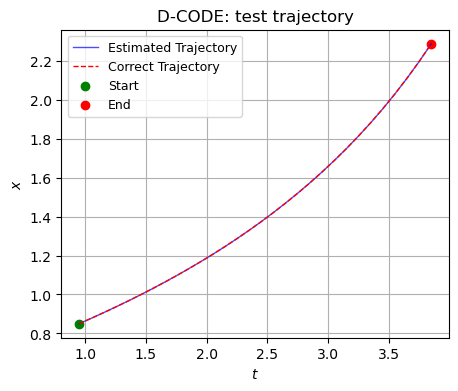

In [43]:
n_test = 10
rmse, _ = evaluate_RMSE(model, ode, freq, n_test, [1., 1., 2.], [0.8, 0.8, 1.], dim_k)
print('D-CODE Model RMSE: ', rmse)

evaluate_sample = 1
ics = [0.85, 0.95, 1.7]
title = 'D-CODE: test trajectory'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=3)

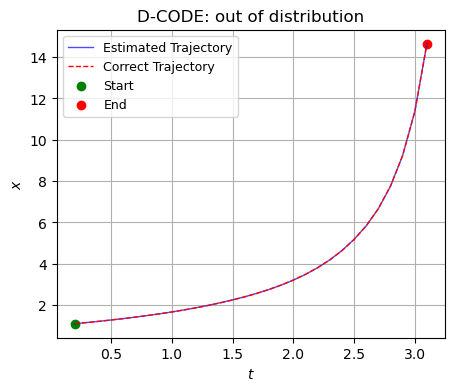

In [44]:
evaluate_sample = 1
ics = [1.1, 0.2, 2]
title = 'D-CODE: out of distribution'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=3)

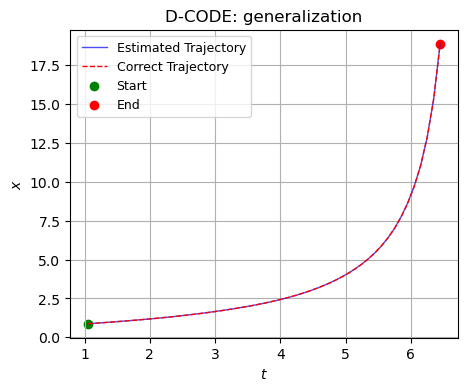

In [45]:
evaluate_sample = 1
ics = [0.85, 0.95, 1.7]
title = 'D-CODE: generalization'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=5.5)